In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd 

import os 

In [31]:
## Task 1
# .ct -> .dbn converter

file = '16s_B.subtilis.ct'

ct_dir = os.path.join(os.getcwd(),'archiveII')
file_loc = os.path.join(ct_dir,file)


 
with open(file_loc,'r') as file:
    lines = file.readlines()
    print( '> ' + lines[0].split('\t')[1] )
    sequence = ''.join( line.split('\t')[1] for line in lines[1:] )
    print( sequence )

    print( ' '.join( line.split('\t')[0] for line in lines[1:] ) )
    print( ' '.join( line.split('\t')[4] for line in lines[1:] ) )
    pairings = [ ( line.split('\t')[0],line.split('\t')[4]) for line in lines[1:]]

> CRW_00074.ct

UUUAUCGGAGAGUUUGAUCCUGGCUCAGGACGAACGCUGGCGGCGUGCCUAAUACAUGCAAGUCGAGCGGACAGGUGGGAGCUUGCUCCCGAUGUUAGCGGCGGACGGGUGAGUAACACGUGGGUAACCUGCCUGUAAGACUGGGAUAACUCCGGGAAACCGGGGCUAAUACCGGAUGGUUGUUUGAACCGCAUGGUUCAAACAUAAAAGGUGGCUUCGGCUACCACUUACAGAUGGACCCGCGGCGCAUUAGCUAGUUGGUGAGGUAACGGCUCACCAAGGCAACGAUGCGUAGCCGACCUGAGAGGGUGAUCGGCCACACUGGGACUGAGACACGGCCCAGACUCCUACGGGAGGCAGCAGUAGGGAAUCUUCCGCAAUGGACGAAAGUCUGACGGAGCAACGCCGCGUGAGUGAUGAAGGUUUUCGGAUCGUAAAGCUCUGUUGUUAGGGAAGAACAAGUACCGUUCGAAUAGGGCGGUACCUUGACGGUACCUAACCAGAAAGCCACGGCUAACUACGUGCCAGCAGCCGCGGUAAUACGUAGGUGGCAAGCGUUGUCCGGAAUUAUUGGGCGUAAAGGGCUCGCAGGCGGUUUCUUAAGUCUGAUGUGAAAGCCCCCGGCUCAACCGGGGAGGGUCAUUGGAAACUGGGGAACUUGAGUGCAGAAGAGGAGAGUGGAAUUCCACGUGUAGCGGUGAAAUGCGUAGAGAUGUGGAGGAACACCAGUGGCGAAGGCGACUCUCUGGUCUGUAACUGACGCUGAGGAGCGAAAGCGUGGGGAGCGAACAGGAUUAGAUACCCUGGUAGUCCACGCCGUAAACGAUGAGUGCUAAGUGUUAGGGGGUUUCCGCCCCUUAGUGCUGCAGCUAACGCAUUAAGCACUCCGCCUGGGGAGUACGGUCGCAAGACUGAAACUCAAAGGAAUUGACGGGGGCCCGCACAAGCGGUGGAGCAUGUGGUUUAAUUCGAAGCAACGCGAAG

The logic, very shortly is:

Send the arc diagram of the sequence to its shape, assign brackets, and then pullback the brackets.
$${\rm s}:{\rm Arcs}\to {\rm Shapes}, \quad {\rm bracketing}:{\rm Shapes}\to {\rm Brackets} $$
$$\Rightarrow {\rm bracketing}^*:{\rm Arcs}\to{\rm Brackets}$$
such that ${\rm bracketing}^*(pair) = {\rm bracketing}(s(pair))$.

A bit more verbose:
1. Consider the rainbow graph or arc diagram (https://en.wikipedia.org/wiki/Arc_diagram) of the primary structure, with the arcs drawn in the upper half plane.
The nodes are elements of the sequence, and they have an arc connecting them if they're paired.
2. Create the "shape", which means that first all the isolated, unconnected nodes are removed. Then, parallel pairs, which is a sequence like ${(A + i, B - i)}_{i\in[0..n]}$ are collapsed or glued to a single ark.
3. Finally, use the shape to assign brackets. Isolated arcs in the "shape" all get "()" pairs. Overlapping arcs get (),<>,[],etc. in a predefined sequence
4. And then make sure everything in the preimage of map 2 has the same bracket (or "no bracket" ie a dot for the unassigned isolated nodes). 


How I implemented the logic was a bit different, in the sense that after step 1., I didn't create the shape immediately, but I first focused on connected components of overlapping/intersecting arcs. 

Then, in each component, I collapsed everything to the shape and assigned brackets.

In [376]:
def prune0arcs(pairs):
    """
    Remove 0-arcs (unconnected pairs) from a list of pairs.
    Rename the surviving pairs so they're sequential
    E.g. (1,x),(2,0),(3,y) -> (f(1),f(x)), --this one died--, (f(3),f(y))
    and f(1)=1, f(3)=2, etc.
    Return the new pairs and the map f.
    """
    first_pairs = [a for a,b in pairs if b!=0]
    rename_pairs_map = { a:(i+1) for i,a in enumerate(sorted(first_pairs))}
    renamed_pairs = [(rename_pairs_map[a],rename_pairs_map[b]) for a,b in pairs if b!=0]
    
    return renamed_pairs, rename_pairs_map

def build_overlap_graph(pairs):
    """
    In a rainbow graph of a primary structure
    where pairs are connected by arcs,
    return a graph in the form of an adjancency list,
    which consists of those pairs whose arcs intersect (this is the pseudoknot condition).
    """
    overlaps = {}
    for i, j in pairs:
        if i < j:  
            overlaps[(i, j)] = []
    for (i1, j1) in pairs:
        for (i2, j2) in pairs:
        # pseudoknot/overlapping arcs condition
            if (i1 < i2 < j1 < j2) or (i2 < i1 < j2 < j1):
                overlaps[(i1, j1)].append((i2, j2))
                overlaps[(i2, j2)].append((i1, j1))
    
    return overlaps

def connected_components(graph):
    """Standard dfs algorithm to find connected components in a graph"""
    visited = set()
    components = []

    def dfs(node, component):
        visited.add(node)
        component.append(node)
        for neighbor in graph.get(node, []):
            if neighbor not in visited:
                dfs(neighbor, component)
    
    for node in graph:
        if node not in visited:
            component = []
            dfs(node, component)
            components.append(component)
    
    return components

def make_dot_bracket(sequence, pairs):
    """
    Creates a dot-bracketed string from a sequence and a list of paris.
    First, remove 0-arcs (unconnected pairs) and rename the pruned sequence.
    Then, build a graph, so that nodes are pairs, and edges connect 
    only those pairs whose arcs intersect (so their topology is nontrivial). 
    Then, focus on connected components of this graph. 
    Give all parallel arcs the same bracket.
    """
    renamed_pairs, rename_pairs_map = prune1arcs(pairs)

    inverse_rename_pairs_map = { v:k for k,v in rename_pairs_map.items()}

    graph = build_overlap_graph(renamed_pairs)
    components = connected_components(graph)
    openbrackets = '(<[{ACEGIKMOQSU'
    closedbrackets = ')>]}BDFHJLNPRTV'
    bracketdict = defaultdict(lambda:'.')

    for component in components:
    
        # e.g. for the component [(1, 6), (2, 7), (4, 9), (5, 8)]
        
        # first sort according to first element
        sorted_renamed_component = sorted( [ (a,b) for a,b in component if a<b], key=lambda x:x[0])
        
        # next, collapse all parallel pairs 
        # which are those like (i,j) and (i+1,j-1) for any i and j
        # to the first pair in such a sequence.
        
        collapsing_parallels_map = {}
        current = sorted_renamed_component[0] # start from first pair
        for k,pair in enumerate(sorted_renamed_component):
            # iterate through pairs and send all parallel pairs to the same target pair 
            if k>1 and sorted_renamed_component[k][1] != sorted_renamed_component[k-1][1] - 1:
                # if not parallel to previous pair, this is a target 
                current = pair
            collapsing_parallels_map[pair] = current
            
        # for our example, 
        # collapsing_parallels_map is {(1, 6): (1, 6), (2, 7): (1, 6), (4, 9): (4, 9), (5, 8): (4, 9)}
        
        # look at the preimage of the collapsing_parallels map
        # e.g. {(1, 6): (1, 6), (2, 7): (1, 6), (4, 9): (4, 9), (5, 8): (4, 9)}
        d = [ (n, [k for k in collapsing_parallels_map.keys() if collapsing_parallels_map[k] == n]) for n in set(collapsing_parallels_map.values()) ]

        # assign the same bracket to everything in a given preimage
        for k,(target,preimage) in enumerate(sorted(d,key=lambda x:x[1][0])):
            for image in preimage:
                bracketdict[ inverse_rename_pairs_map[image[0]]]= openbrackets[k]
                bracketdict[ inverse_rename_pairs_map[image[1]]]= closedbrackets[k]
           
    return ''.join( bracketdict[i] for i in range(1,len(sequence)+1))

def ct2dbn(source_filename,target_filename):
    """
    Converts .ct file to .dbn file. 
    """
    ct_dir = os.path.join(os.getcwd(),'archiveII')
    file_loc = os.path.join(ct_dir,source_filename)

    print('reading:')
    with open(file_loc,'r') as file:
        lines = file.readlines()
        name = lines[0].split()[1]
        print( '> ' + name )
        sequence = ''.join( line.split()[1] for line in lines[1:] )

        print( ' '.join( line.split()[0] for line in lines[1:] ) )
        print( ' '.join( line.split()[4] for line in lines[1:] ) )
        pairings = [ ( line.split()[0],line.split()[4]) for line in lines[1:]]
        
    pairs = [ (int(a),int(b)) for a,b in pairings ]
    
    print('writing...')
    with open( os.path.join(ct_dir,target_filename),'w') as file:
        file.write('>'+name)
        file.write(sequence+'\n')
        file.write(make_dot_bracket(sequence, pairs))
    print('wrote:')
    with open( os.path.join(ct_dir,target_filename),'r') as file:
        print(file.read())
        


In [292]:
ct2dbn('16s_B.subtilis.ct','16s_B.subtilis.dbn')

reading:
> CRW_00074.ct

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271

In [336]:

ct_dir = os.path.join(os.getcwd(),'archiveII')
file_loc = os.path.join(ct_dir,'23s_E.coli.ct')

with open(file_loc,'r') as file:
        lines = file.readlines()
        name = lines[0].split()[1]
        print( '> ' + name )
        sequence = ''.join( line.split()[1] for line in lines[1:] )

        print( ' '.join( line.split()[0] for line in lines[1:] ) )
        print( ' '.join( line.split()[4] for line in lines[1:] ) )
        pairings = [ ( line.split()[0],line.split()[4]) for line in lines[1:]]
        
pairs = [ (int(a),int(b)) for a,b in pairings ]

renamed_pairs, rename_pairs_map = collapse_to_shape(pairs)

inverse_rename_pairs_map = { v:k for k,v in rename_pairs_map.items()}

graph = build_overlap_graph(renamed_pairs)
components = connected_components(graph)
openbrackets = '(<[{'
closedbrackets = ')>]}'
bracketdict = defaultdict(lambda:'.')

for component in components:

        sorted_renamed_component = sorted( [ (a,b) for a,b in component if a<b], key=lambda x:x[0])
        collapsing_parallels_map = {}
        current = sorted_renamed_component[0]  
        for k,pair in enumerate(sorted_renamed_component):
                if k>1 and sorted_renamed_component[k][1] != sorted_renamed_component[k-1][1] - 1:
                  current = pair
        collapsing_parallels_map[pair] = current
        
        d = [ (n, [k for k in collapsing_parallels_map.keys() if collapsing_parallels_map[k] == n]) for n in set(collapsing_parallels_map.values()) ]

        for k,(target,preimage) in enumerate(sorted(d,key=lambda x:x[1][0])):
          for image in preimage:
                        bracketdict[ inverse_rename_pairs_map[image[0]]]= openbrackets[k]
                        bracketdict[ inverse_rename_pairs_map[image[1]]]= closedbrackets[k]

''.join( bracketdict[i] for i in range(1,len(sequence)+1))

> CRW_00492.ct
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 2

'((((((((.....................................((......(((..............................(.......)..................)))....(((....)))(((((((....))))))).(((((((((.........))))))))).))...((((((.....((....))......))))).).........((....))...(((((.....((.....))....)))))........((((......(((((((((((((.(((...(((((......)))))..(...)...(.......).....)))...)))))))))))))...))))........((((((((.........)))))))).............................................................((....))...............((((.....))))..................................(.((((..((((((....))))))..))))...(.(........).).((((((....(((((((((((((..((((..((.....))..))))...((....))..((((.....)))).....)))))))))))))..((.(...((((((...((((((((((((.((((...((((((......))))))....))))...(((.(((((........))))))))..).))))))))))).(((.....)))......))))))......).))..((((((....(((((....))))).((((((((..((((((((((.....(((...(((.((((...(((((((.....))))).))...)))).)))..)).).....)))))).)))..)))))))).)...((((((((((......))))))))))....(((......)))...((((.(((.

In [403]:
from collections import Counter
parsed = []
pair_counter = Counter()
letter_counter = Counter()
num_files = 0
pk_count = 0
perc_unpaired = []
fully_unpaired = 0
len_fully_unpaired = []
name_fully_unpaired=[]
triples = defaultdict(list)
seq_lengths = []
for filename in os.listdir(ct_dir):
    num_files += 1
    if filename[-3:]=='.ct':
        with open(os.path.join(ct_dir,filename),'r') as ctfile:
            lines = ctfile.readlines()
            try:
                rna = ''.join( line.split()[1] for line in lines[1:] ) 
            except:
                print(filename)
                continue
            seq_lengths.append(len(rna))
            pairings = [ ( line.split()[0],line.split()[4]) for line in lines[1:]]
            pairs = [ (int(a),int(b)) for a,b in pairings ]
            unpaired = 100*len( [ 1 for a,b in pairs if b==0])/len(pairs)
            perc_unpaired.append(unpaired)
            if len( [ 1 for a,b in pairs if b==0]) == len(pairs):
                fully_unpaired += 1
                len_fully_unpaired.append(len(rna))
                name_fully_unpaired.append(filename)
            try:
                dbn_this = make_dot_bracket(rna,pairs)
                if '<' in dbn_this:
                    pk_count += 1
                triples[rna].append([filename,dbn_this])
            except:
                print('dbn error:',filename)
                continue
            ord_pairings = [(int(pair[0]),int(pair[1]) ) for pair in pairings if int(pair[1])!=0 and int(pair[0]) < int(pair[1])]
            letter_ord_pairings = [ ''.join(sorted([rna[l-1],rna[r-1]])) for l,r in ord_pairings]
            pair_counter.update(letter_ord_pairings)
            letter_counter.update(rna)
            

In [382]:
letter_counter

Counter({'G': 251708, 'C': 210354, 'U': 182259, 'A': 203608})

In [360]:
pair_counter

Counter({'CG': 136597, 'GU': 30610, 'AU': 65368})

In [344]:
num_files

7991

In [368]:
pk_count/num_files

0.1355274684019522

In [369]:
np.mean(perc_unpaired)

44.496199256092105

213.3154716981132 192.7071531954692
2968


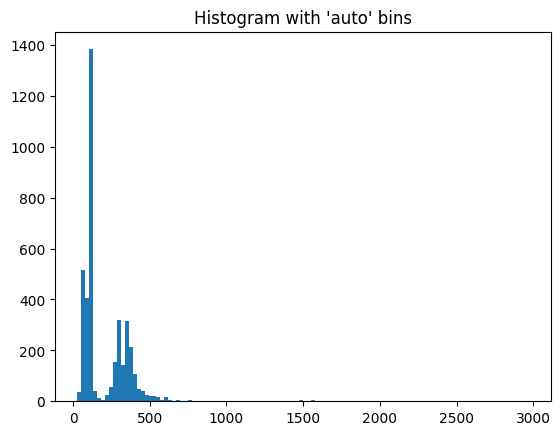

In [410]:
print(np.mean(seq_lengths), np.sqrt(np.var(seq_lengths)) )
print(np.max(seq_lengths))
import matplotlib.pyplot as plt

plt.hist( np.array(seq_lengths), bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [404]:
np.histogram(np.array(seq_lengths))

(array([3020,  905,   23,    3,    6,    7,    6,    0,    0,    5]),
 array([  28.,  322.,  616.,  910., 1204., 1498., 1792., 2086., 2380.,
        2674., 2968.]))

In [372]:
fully_unpaired

5

In [373]:
len_fully_unpaired

[58, 95, 143, 58, 58]

In [375]:
name_fully_unpaired

['srp_Leis.aeth._AY722730.ct',
 'srp_Schi.pomb._AU010514.ct',
 '16s_M.polymorpha_domain4.ct',
 'srp_Crit.luci._AY781798.ct',
 'srp_Crit.fasc._AY781797.ct']

In [355]:
def counter_to_relative(counter):
    total_count = sum(counter.values())
    relative = {}
    for key in counter:
        relative[key] = counter[key] / total_count
    return relative

list(counter_to_relative(pair_counter).items())

[(('C', 'G'), 0.5873245189723745),
 (('G', 'U'), 0.13161345802429325),
 (('A', 'U'), 0.2810620230033323)]

<AxesSubplot: >

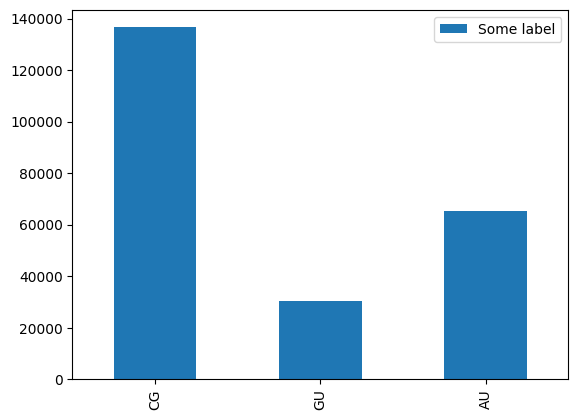

In [361]:
df = pd.DataFrame.from_dict(pair_counter, orient='index', columns=['Some label'])
df.plot.bar()

<AxesSubplot: >

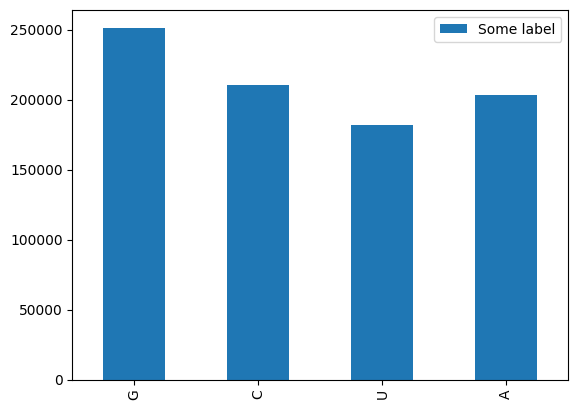

In [411]:
df = pd.DataFrame.from_dict(letter_counter, orient='index', columns=['Some label'])
df.plot.bar()

In [402]:
for k,v in triples.items():
    if len(v)>2:
        new_dict = defaultdict(list)
        for name,ss in v:
            new_dict[ss].append(name)
        print(new_dict)

defaultdict(<class 'list'>, {'(((((((.............(((((((......(((...((((((((((((((<<<<<<..)))))......>>>>>>..............................((.(((((((.........)))).))).))(((((((((((..(((..<<<<<<)))..))))....)))))))..........>>>>>>...(((....((((..<<<<))))....)))...........>>>>...(((.((((((.(((.<<<<<<<))).)))))).))).........>>>.>>>>...)))))...))))...))).....)))))))...(((((.......))))))))))))....': ['tmRNA_Yers.pseu._AR948532_1-364.ct', 'tmRNA_Yers.pest._AE009952_1-364.ct', 'tmRNA_Yers.pest._AL590842_1-364.ct', 'tmRNA_Yers.pest._CP000305_1-364.ct', 'tmRNA_Yers.pest._CP000308_1-364.ct', 'tmRNA_Yers.pest._AE017042_1-364.ct']})
defaultdict(<class 'list'>, {'(((......((((....(((....)))....))))...)))': ['srp_Rhod.spha._CP000661.ct', 'srp_Rhiz.legu._AM236080.ct', 'srp_Novo.arom._CP000248.ct', 'srp_Rhod.spha._CP000143.ct']})
defaultdict(<class 'list'>, {'(((((((((....((((((((.....((((((............))))...))....)))))).)).((((.......(((((.(((....))))))))......)))).)))))))))': ['5s_Fusarium-lunulospo

In [396]:
standard_bases = set("ACGU1")
nonstandard = set()
seq_letter_counter =Counter()
for filename in os.listdir(ct_dir):
    if filename[-4:]=='.seq':
        with open(os.path.join(ct_dir,filename),'r') as ctfile:
            lines = ctfile.readlines()
            rna = lines[2][:-2]
            seq_letter_counter.update(rna)
            for seq in rna:
                for char in seq:
                    if char not in standard_bases:
                        nonstandard.add(char)
                        if (filename[-4:]+'.ct' in os.listdir(ct_dir)):
                            print(filename)
                

In [397]:
seq_letter_counter

Counter({'U': 183097,
         'G': 253881,
         'C': 212279,
         'A': 205274,
         'g': 304,
         'u': 761,
         'a': 332,
         'N': 295,
         'S': 2,
         'c': 28,
         'Y': 1,
         'R': 1})